# **Example Aggregation Zones**

In some case it is useful to group objects in specific zones to facilitate analysis and/or visualization of the model result. This jupyter notebook demonstrates how to create a **spatial joint** of the FIAT model data with single or multiple **aggregation zones**. 
<p>A basic FIAT model can be set up by following the steps from the example notebook <a href="(https://github.com/Deltares/hydromt_fiat/blob/%2364FlexibleAggregationArea/examples/global_OSM_JRC.ipynb)"><em>global_OSM_JRC.ipynb</em></a>.

<em>Note: In this notebook the model was already initialized. Unless the user does not wish to use own data, there is `no need` to create a new model and the user can simply continue with the example data of this jupyter notebook.</p></em>

# **Before we start:** Study area and aggregation zones


<p>In this notebook we will join three different aggregation zones to the exposure data. This means the zone, in which an object falls, will be assigned to the object. </p>

The aggregation zones handled in this notebook are:
- **Base_zones**
- **Land_use**
- **Horse_Carriage_Tracks** 

This data was obtained from https://gis.charleston-sc.gov/

**Let's have a look at the study area and the aggregation zones that we would like to join spatially!**

The different `aggregation zone vector files` are loaded into the notebook as **GeoDataFrames** and plotted on top of a basemap. The `red dots` display our `original exposure data` , which are joined spatially to the aggregation zones in the following steps. 


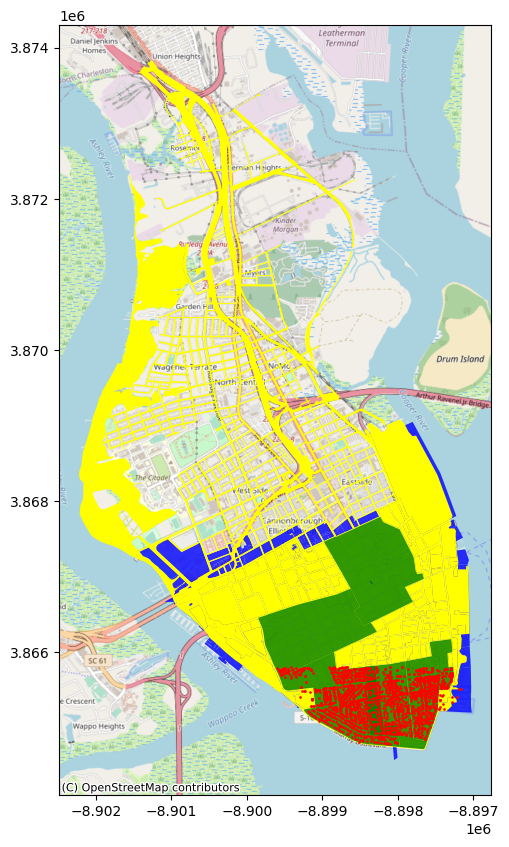

In [220]:
import folium
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
import pandas as pd

#Load aggregation zones as GeoDataFrames
orig_exp=gpd.read_file(Path(os.path.abspath("")) / "data" / "aggregation_zones_example" / "exposure" / "exposure.gpkg")
base_zone=gpd.read_file(Path(os.path.abspath("")) / "data" / "aggregation_zones_example" / "aggregation_zones" / "base_zones.gpkg")
land_use=gpd.read_file(Path(os.path.abspath("")) / "data" / "aggregation_zones_example" / "aggregation_zones" / "land_use.gpkg")
horse_carriage =gpd.read_file(Path(os.path.abspath("")) / "data" / "aggregation_zones_example" / "aggregation_zones" / "horse_carriage_track.gpkg")

# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the aggregation layers 
base_zone = base_zone.to_crs(epsg=3857)  # Reproject to Web Mercator for basemap compatibility
base_zone.plot(ax=ax, color='blue', label='Base_zones', alpha=0.8)
land_use = land_use.to_crs(epsg=3857)  # Reproject to Web Mercator for basemap compatibility
land_use.plot(ax=ax, color='yellow', label='Land_use')
horse_carriage = horse_carriage.to_crs(epsg=3857)  # Reproject to Web Mercator for basemap compatibility
horse_carriage.plot(ax=ax, color='green', label='Horse_Carriage', alpha=0.8)

# Plot the original exposure objects
orig_exp = orig_exp.to_crs(epsg=3857)  # Reproject to Web Mercator for basemap compatibility
orig_exp.plot(ax=ax, color='red', label='exposure_data', markersize = 0.8)

# Add a basemap (in this case, using OpenStreetMap)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# **Step 0**: Create and activate the FIAT environment 
Using a <em>yaml</em> file, the neccessary environment is created and activated to run this notebook.
<p>---see this code </p>

# **Step 1**: Import required packages

Now we can import the neccessary python packages in our environment to build the **FIAT model**.

In [137]:
#Import the required python packages to run this notebook. 
import os
from typing import Sequence
from _pytest.mark.structures import ParameterSet
from hydromt_fiat.fiat import FiatModel
from hydromt.log import setuplog
from pathlib import Path
import pytest
from hydromt_fiat.fiat import workflows
import json
import hydromt_fiat
from hydromt_fiat import workflows
import hydromt
from hydromt import workflows
import yaml

#from hydromt_fiat.workflows.exposure_vector import ExposureVector
#from hydromt_fiat.workflows.vulnerability import Vulnerability
#from hydromt_fiat.workflows.aggregation_areas import join_exposure_aggregation_areas
#from hydromt_fiat.workflows.aggregation_areas import join_exposure_aggregation_multiple_areas

# **Step 2**: Configure and initialize the FIAT model

In this notebook the **FIAT model** was already initialized and the data is stored in the <em>"example"/ "data" / "example_aggregation_zone" </em> - directory. 
<p> The study area is located in Charelston, United States. Input data was obtained from <strong>there and there </strong> </p>

<em> Note: To configure and initialize your **own** FIAT model refer to  <a href="(https://github.com/Deltares/hydromt_fiat/blob/%2364FlexibleAggregationArea/examples/global_OSM_JRC.ipynb)"><em>global_OSM_JRC.ipynb</em></a>. If you do so, `do not` forget to update the folder dependencies and variables throughout this notebook according to your data. </em> 

# **Step 3**: Define aggregation parameters in the <em>yaml</em> file 

Two test cases are created in this jupyter notebook. First, the **spatial joint** of a **single** aggregation zone to the exposure data. Second, the **spatial joint** of **multiple** aggregation zones.

The test_case configuration is saved in a <em>yaml</em> file, in which the following parameters are specified:
- **new_root** (Directory path in which the new model output should be stored) 
- **aggregation_area_fn** (File path to the aggregation vector file) 
- **attribute_names** (name of the column that specifies the aggregation zone in the aggregation vector file(case-sensitive)) 
- **label_names** (new aggregation label name, chosen by the user)

<em>In this case below, the column `"ZONE_BASE"`categorizes the aggregation zones in the vector file. This column name is used for `attribute_names` . <em>

![attribute_name.png](img/Aggregation_zones.PNG)

## **Step 3.1:** Load the information of the <em>yaml</em> file

<p>The <em>yaml</em> file is located in the <em>"example"/ "data" /</em>  - folder. The information in the file are read and converted into a python dictionary. </p>
<p><em>Note: Instead of loading a yaml file it is possible to create a python dictionary directly, built upon the structure seen below.</em></p>

In [77]:
#Let's read the yaml file with the required information 
#and set up the FIAT model for the two test cases. 

with open(Path(os.path.abspath("")) / "data" / "aggregation_zones_example" / "config_aggregation.yml", 'r') as file:
    config_aggregation = yaml.safe_load(file)

print(json.dumps(config_aggregation, indent=4, sort_keys=False))

{
    "cases": {
        "test1_single_aggregation": {
            "new_root": "examples/data/Aggregation_zones_example/output/aggregation_zones_test1",
            "configuration": {
                "setup_aggregation_areas": {
                    "aggregation_area_fn": "examples/data/Aggregation_zones_example/Aggregation_zones/base_zones.gpkg",
                    "attribute_names": "ZONE_BASE",
                    "label_names": "Base_zones"
                }
            }
        },
        "test2_multiple_aggregation": {
            "new_root": "examples/data/Aggregation_zones_example/output/aggregation_zones_test2",
            "configuration": {
                "setup_aggregation_areas": {
                    "aggregation_area_fn": [
                        "examples/data/Aggregation_zones_example/Aggregation_zones/base_zones.gpkg",
                        "examples/data/Aggregation_zones_example/Aggregation_zones/land_use.gpkg",
                        "examples/data/Aggregatio

# **Step 4**: <strong>Define variables for the FIAT model</strong>

Set up the root path to the FIAT model and the logger settings to re-build your model:
- `root`: Directory path from where the neccessary data for the FIAT model is stored.  </p>
- `logger`: The logger variable defines the frequencies of log-entries during the initialisation of the model.</p>

In [83]:
# Set up Fiat Model
root = Path(os.path.abspath("")) / "data" / "aggregation_zones_example"
# Set up the logger
logger = setuplog("hydromt_fiat", log_level=10)

2023-10-02 12:27:00,250 - hydromt_fiat - log - INFO - HydroMT version: 0.8.0


# **Test case 1**: Run the FIAT model

It's time to run the model with the new configuration of the aggregation zones. The output will be 
stored in the prior defined <em>`"new_root"`</em> - directory. The output will be a **new <em>exposure.csv</em>**, in which each object is assigned **spatially** to an `aggregation zone`. 

In [84]:
#Start running the new model with the new exposure output 
fm = FiatModel(root=root, mode="r", logger=logger)
fm.read()
fm.build(write=False, opt=config_aggregation["cases"]["test1_single_aggregation"]["configuration"])
fm.set_root(config_aggregation["cases"]["test1_single_aggregation"]["new_root"])
fm.write()

2023-10-02 12:27:02,746 - hydromt_fiat - log - DEBUG - Appending log messages to file c:\Users\rautenba\hydromt_fiat\examples\data\aggregation_zones_example\hydromt.log.
2023-10-02 12:27:02,746 - hydromt_fiat - model_api - INFO - Initializing fiat model from hydromt_fiat (v0.2.0).
2023-10-02 12:27:02,746 - hydromt_fiat - fiat - INFO - Reading model data from c:\Users\rautenba\hydromt_fiat\examples\data\aggregation_zones_example
2023-10-02 12:27:02,746 - hydromt_fiat - model_api - ERROR - Model config file not found at c:\Users\rautenba\hydromt_fiat\examples\data\aggregation_zones_example\fiat_configuration.ini
2023-10-02 12:27:02,746 - hydromt_fiat - model_api - ERROR - Model config file not found at c:\Users\rautenba\hydromt_fiat\examples\data\aggregation_zones_example\fiat_configuration.ini


TypeError: 'NoneType' object is not iterable

# **Test case 2**: Run the FIAT model

In [101]:
#Start running the new model with the new exposure output 
fm = FiatModel(root=root, mode="r", logger=logger)
fm.read()
fm.build(write=False, opt=config_aggregation["cases"]["test2_multiple_aggregation"]["configuration"])
fm.set_root(config_aggregation["cases"]["test2_multiple_aggregation"]["new_root"])
fm.write()

2023-10-02 14:02:11,407 - hydromt_fiat - model_api - INFO - Initializing fiat model from hydromt_fiat (v0.2.0).
2023-10-02 14:02:11,409 - hydromt_fiat - fiat - INFO - Reading model data from c:\Users\rautenba\hydromt_fiat\examples\data\aggregation_zones_example
2023-10-02 14:02:11,410 - hydromt_fiat - model_api - ERROR - Model config file not found at c:\Users\rautenba\hydromt_fiat\examples\data\aggregation_zones_example\fiat_configuration.ini
2023-10-02 14:02:11,411 - hydromt_fiat - model_api - ERROR - Model config file not found at c:\Users\rautenba\hydromt_fiat\examples\data\aggregation_zones_example\fiat_configuration.ini


TypeError: 'NoneType' object is not iterable

# **Done!**  
Your **FIAT model** created a **spatial joint** with your original objects and the aggregation zones. <p>Let's have a look at the output!</p>

# **Result**

Load the newly created *.csv file from the <em>"output"</em> -folder and create a dataframe for **Test case 1**

In [107]:
#Load exposure.csv
df_single_aggregation = pd.read_csv(Path(os.path.abspath("")) / "data" / "aggregation_zones_example" / "output" / "exposure.csv")

Display the dataframe for **Test case 1**. Aggregation zones are on the right of the dataframe.

In [116]:
#Display dataframe
df_single_aggregation

,Object ID,Object Name,Primary Object Type,Secondary Object Type,Max Potential Damage: Structure,Max Potential Damage: Content,Ground Elevation,X Coordinate,Y Coordinate,Aggregation Label: Census Block,Ground Floor Height,Extraction Method,Damage Function: Structure,Damage Function: Content,geometry,Zoning_map,Land_use_map
0,574486973,574486973,RES,RES3A,480189.335,240094.667,7.298348,-79.936825,32.776883,4.500000e+14,1,centroid,RES3A,RES3A,POINT (-79.93682513 32.776882893),DR-1F,Neighborhood
1,573783417,573783417,COM,RES4,1177614.200,588807.100,8.381749,-79.930000,32.770545,4.500000e+14,1,centroid,RES4,RES4,POINT (-79.93000008 32.770545239),SR-3,Neighborhood
2,573783433,573783433,COM,RES4,476216.254,238108.127,7.374184,-79.929684,32.771271,4.500000e+14,1,centroid,RES4,RES4,POINT (-79.92968382 32.771271301),SR-4,Neighborhood
3,573785665,573785665,RES,RES1-2SNB,330007.420,165003.710,7.364031,-79.931796,32.773365,4.500000e+14,1,centroid,RES1-2SNB,RES1-2SNB,POINT (-79.93179589 32.773364727),SR-5,Neighborhood
4,574346729,574346729,RES,RES3A,472285.148,236142.574,10.902031,-79.930645,32.774854,4.500000e+14,1,centroid,RES3A,RES3A,POINT (-79.93064525 32.774854333),SR-5,Neighborhood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,574488834,574488834,RES,RES1-3SNB,384398.576,192199.288,12.906374,-79.929518,32.774706,4.500000e+14,1,centroid,RES1-3SNB,RES1-3SNB,POINT (-79.92951787 32.774706172),SR-5,Neighborhood
1990,574488837,574488837,RES,RES3A,480189.335,240094.667,13.259127,-79.928910,32.775093,4.500000e+14,1,centroid,RES3A,RES3A,POINT (-79.92891 32.77509288),SR-5,Neighborhood
1991,574488848,574488848,RES,RES1-2SNB,322415.251,161207.625,13.143233,-79.927631,32.774979,4.500000e+14,1,centroid,RES1-2SNB,RES1-2SNB,POINT (-79.92763108 32.774978951),SR-5,Neighborhood
1992,574488851,574488851,RES,RES1-2SNB,222897.785,111448.892,10.150554,-79.926715,32.775554,4.500000e+14,1,centroid,RES1-2SNB,RES1-2SNB,POINT (-79.92671547 32.775554202),DR-1F,Neighborhood


Load the newly created *.csv file from the <em>"output"</em> -folder and create a dataframe for **Test case 2**

In [118]:
#Load exposure.csv
df_multiple_aggregation = pd.read_csv(Path(os.path.abspath("")) / "data" / "aggregation_zones_example" / "output" / "exposure.csv")

Display the dataframe for **Test case 2**. Aggregation zones are on the right of the dataframe.

In [119]:
#Display dataframe
df_multiple_aggregation

,Object ID,Object Name,Primary Object Type,Secondary Object Type,Max Potential Damage: Structure,Max Potential Damage: Content,Ground Elevation,X Coordinate,Y Coordinate,Aggregation Label: Census Block,Ground Floor Height,Extraction Method,Damage Function: Structure,Damage Function: Content,geometry,Zoning_map,Land_use_map
0,574486973,574486973,RES,RES3A,480189.335,240094.667,7.298348,-79.936825,32.776883,4.500000e+14,1,centroid,RES3A,RES3A,POINT (-79.93682513 32.776882893),DR-1F,Neighborhood
1,573783417,573783417,COM,RES4,1177614.200,588807.100,8.381749,-79.930000,32.770545,4.500000e+14,1,centroid,RES4,RES4,POINT (-79.93000008 32.770545239),SR-3,Neighborhood
2,573783433,573783433,COM,RES4,476216.254,238108.127,7.374184,-79.929684,32.771271,4.500000e+14,1,centroid,RES4,RES4,POINT (-79.92968382 32.771271301),SR-4,Neighborhood
3,573785665,573785665,RES,RES1-2SNB,330007.420,165003.710,7.364031,-79.931796,32.773365,4.500000e+14,1,centroid,RES1-2SNB,RES1-2SNB,POINT (-79.93179589 32.773364727),SR-5,Neighborhood
4,574346729,574346729,RES,RES3A,472285.148,236142.574,10.902031,-79.930645,32.774854,4.500000e+14,1,centroid,RES3A,RES3A,POINT (-79.93064525 32.774854333),SR-5,Neighborhood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,574488834,574488834,RES,RES1-3SNB,384398.576,192199.288,12.906374,-79.929518,32.774706,4.500000e+14,1,centroid,RES1-3SNB,RES1-3SNB,POINT (-79.92951787 32.774706172),SR-5,Neighborhood
1990,574488837,574488837,RES,RES3A,480189.335,240094.667,13.259127,-79.928910,32.775093,4.500000e+14,1,centroid,RES3A,RES3A,POINT (-79.92891 32.77509288),SR-5,Neighborhood
1991,574488848,574488848,RES,RES1-2SNB,322415.251,161207.625,13.143233,-79.927631,32.774979,4.500000e+14,1,centroid,RES1-2SNB,RES1-2SNB,POINT (-79.92763108 32.774978951),SR-5,Neighborhood
1992,574488851,574488851,RES,RES1-2SNB,222897.785,111448.892,10.150554,-79.926715,32.775554,4.500000e+14,1,centroid,RES1-2SNB,RES1-2SNB,POINT (-79.92671547 32.775554202),DR-1F,Neighborhood
